<h1 style="color:red" align="center">Neural Networks: The basics made for all</h1>
<p align="center">By Bastien Lhopitallier and Robin Sobczyk</p>

<h2 style="color:green" align="center">Course 1: Your first networks</h2>

Here are the topics we will cover in this course:
- how do we train a neural network (forward pass, backpropagation)
- how to code a neural network from scratch
- PyTorch and autograd (automatic differentiation)
- how to setup the training on a CPU or a GPU
- how to code a neural network with PyTorch and train it
- how to save and load your model
- classic forms of training

In [1]:
# Imports for the code
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from tqdm import tqdm
from pathlib import Path

<h3 style="color:skyblue">The concepts behind network training</h3>

Mathematically, a neural network can be represented as a function. The [universal approximation theorems](https://en.wikipedia.org/wiki/Universal_approximation_theorem) (you can think of [Stone-Weierstrass](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem) under steroids) are theorems that ensure the existence of networks corresponding to functions that are arbitrarily close to any objective function. We talk about the density of neural networks in the studied function space. Most often, these theorems are about specific families of neural networks. These theorems ensure that our networks can yield good results under good asumptions, and that training them is not pointless.

Let's now explain the process of training a neural network in detail. Training a network consists in tuning all its parameters so that it becomes better at what it's been created for. In order to do so, we need to select a function that takes as input all the parameters of the network and outputs a value that is inversely proportional to the performance of the newtork (because most frameworks are programmed to minimize such values, in reality it the output value could be proportional to the performance). For this reason, we call it the loss function: the higher its value, the worse the network is. Usually, we directly use the outputs of the network to compute its values without considering all its parameters, as the outputs already depend on them.

Then, we use a method called gradient descent. Its principle is the following: we want to find an acceptable minimum of the loss function (i.e. a better network), so we look at the gradient at the point corresponding to the current network parameters, and we shift the parameters so that we go "down the slope".

For example, if we visualize the loss function as a multi-dimensional surface (each axis corresponding to one paramater of the network), we can consider the (very) simple case of a network with two parameters $x$ and $y$ with the loss function $f = - x \times \exp(-x^2 - y^2)$ around $(0, 0)$. Its surface then looks like this:

In [ ]:
# Create a surface
x = np.arange(-2, 2, 0.01)
y = np.arange(-2, 2, 0.01)
X, Y = np.meshgrid(x, y)

# Compute f on the points of the surface
f = -X * np.exp(-X * X - Y * Y)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
_ = ax.plot_surface(X, Y, f, cmap="rainbow")

We can see that the minimum would be easy to find using gradient descent. However the surface can have multiple local minima, for example it could look like this:

In [ ]:
x = np.arange(-3, 3, 0.01)
y = np.arange(-3, 3, 0.01)
X, Y = np.meshgrid(x, y)
f = -X * np.cos(-X * X - Y * Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
_ = ax.plot_surface(X, Y, f, cmap="rainbow")

which makes the task harder. This is the same when the network gets deeper and deeper: there are numerous parameters, each one needing to be tuned according to the loss value. The question is: how can we do this when our network has several million parameters spread across tens of layers?

And the answer is: the chain rule!

Recall that the chain rule is a formula used to compute the derivative of the composition of two functions $f$ and $g$ using their derivatives. If $h = g \circ f$:
$$
h'(x) = g'(f(x)) \times f'(x)
$$
or if we denote $h = g(u)$ and $u = f(x)$, we can use the Leibniz notation:
$$
\dfrac{dh}{dx} = \dfrac{dh}{du} \times \dfrac{du}{dx}
$$
Now to do the gradient descent, if we denote $L$ the loss function, we need to compute $\dfrac{\partial L}{\partial x}$ for each parameter $x$ of each layer. The chain rule allows us to do this in two steps:
- the forward pass, where we feed our inputs to the model to compute our loss and all the values we need to compute the chain rule derivatives for all layers,
- the backward pass, where we compute the gradients layer by layer starting from the last one and propagate the parameter shifts through the network. This step is often called the backpropagation.

The image below shows how the chain rule enables a propagation of the derivatives, from a neuron point of view:

<div style="max-width:500px;margin-right: auto; margin-left: auto;">

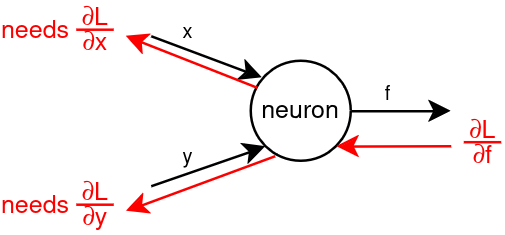

</div>

Suppose we have access to the backpropagated $\dfrac{\partial L}{\partial f}$ (on the right). The parameters $x$ and $y$ respectively need $\dfrac{\partial L}{\partial x}$ and $\dfrac{\partial L}{\partial y}$ to be updated. Thanks to the chain rule, we can decompose the computations:
$$
\dfrac{\partial L}{\partial x} = \dfrac{\partial L}{\partial f} \times \dfrac{\partial f}{\partial x} \qquad \dfrac{\partial L}{\partial y} = \dfrac{\partial L}{\partial f} \times \dfrac{\partial f}{\partial y}
$$

We know $\dfrac{\partial L}{\partial f}$, and the derivatives $\dfrac{\partial f}{\partial x}$ and $\dfrac{\partial f}{\partial y}$ can be computed because we have access to the three parameters $x$, $y$ and $f$ (they're all linked to this specific neuron and not located in another layer).

Then we can update the parameters using the formula $x_{new} = x - \lambda \dfrac{\partial L}{\partial x}$, where $\lambda$ is a coefficient called the "learning rate". Note that we put a minus sign to shift the parameter "against" the gradient.

Shifting all parameters individually does not guarantee that the loss will decrease (maybe we went "too far" on the surface), this is why there is a learning rate, so we can (for example) decrease it throughout the training to ensure we stay close to a loss minimum.

Here is another image to summarize the two training steps:

<div style="max-width:600px;margin-right: auto; margin-left: auto;">

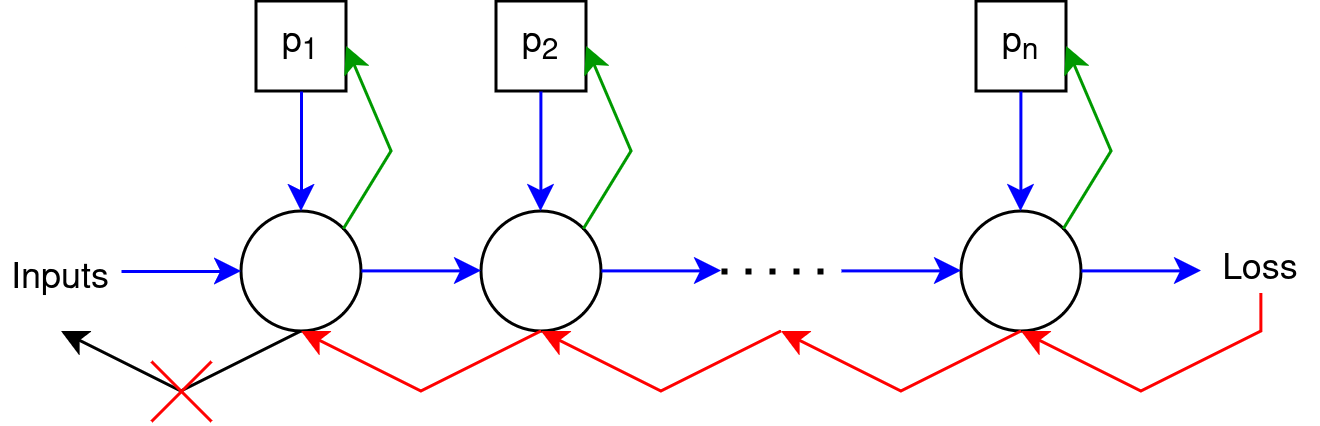

</div>

Firstly, during the forward pass, the inputs are fed to the network, which computes its output using the sets of parameters $p_1,p_2,\ldots,p_n$ (corresponding to the blue arrows). Then, the loss is computed from the outputs: the backward propagation can begin!

Then, the gradients are propagated through the network (starting from the last layers, represented by the red arrows) and are used to update its sets of parameters (represented by the green arrows).

These two steps can then be repeated for a given number of times, or until the loss reaches an acceptable value.

<h3 style="color:skyblue">Designing a network, from scratch!</h3>

Now let us use numpy to code a linear neural network (another name for a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)) from scratch! Let's start by presenting the task we will try to solve.

Here is a dataset composed of two sets of points (the two moons) that your network will have to separate:

In [4]:
# Function to visualize the dataset
def plot_clusters(ax, points, cluster):
    ax.scatter(points[:, 0], points[:, 1], s=1, c=cluster, cmap="bwr")

In [ ]:
X, Y = make_moons(n_samples=2000, noise=0.1)
fig, ax = plt.subplots(1, 1)
plt.axis("off")
plot_clusters(ax, X, Y)

Let's code the activation functions. We will use the [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and a [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function):

In [6]:
class ReLU(object):
    def forward(self, x):
        # The formula for the ReLu is y = max(0, x), component-wise

        # === YOUR CODE ===
        self.y = ...
        # =================
        return self.y

    def backward(self, grad_output):
        # Thus the gradient is 1 if x > 0, 0 if not, component-wise
        # Also, because this is the function for the backward propagation, we also
        # multiply by the previous gradient to propagate the chain rule.

        # === YOUR CODE ===
        return ...
        # =================

    def step(self, learning_rate):
        # ReLu doesn't have parameters to update, nothing to do here
        pass


class Sigmoid(object):
    def forward(self, x):
        # The formula for the the sigmoid is y = 1./(1 + exp(-x)), component-wise
        # Also here we save x as we will need it for the backward function

        self.x = x

        # === YOUR CODE ===
        return ...
        # =================

    def backward(self, grad_output):
        # The formula for the partial derivative is e^-x / (e^-x + 1)^2, and
        # we multiply by the propagated gradient again

        # === YOUR CODE ===
        return ...
        # =================

    def step(self, learning_rate):
        # Same as for the ReLU, no parameters to update
        pass

You can try the two classes:

In [ ]:
print(X[0])

relu = ReLU()
print(relu.forward(X[0]))
print(relu.backward(1.0))

sigmoid = Sigmoid()
print(sigmoid.forward(X[0]))
print(sigmoid.backward(1.0))

Now you'll implement a class for a linear layer, which is a layer representing a multiplication by a matrix $W$ (the weights) followed by an addition with a column vector $b$ (the bias).

The following formulae will help you for the backward function ($in$ is the number of inputs of the layer, $out$ is its number of outputs). We take the convention used in the [Matrix calculus](https://en.wikipedia.org/wiki/Matrix_calculus), stating that a vector is a matrix with a single column.
$$
x = \begin{pmatrix}x_1\\\vdots\\ x_{in}\end{pmatrix} \qquad y = \begin{pmatrix}y_1\\\vdots\\ y_{out}\end{pmatrix} \qquad y_i = \sum_j W_{i,j} x_j + b_i
$$
so:
$$
\dfrac{\partial y_i}{\partial W_{i,j}} = x_j
$$
by backpropagation we have access to $\dfrac{\partial L}{\partial y_i}$:
$$
\dfrac{\partial L}{\partial y_i} \overset{def}{=} \texttt{grad\_output\lbrack i\rbrack}
$$
thus by the chain rule:
$$
\boxed{
\dfrac{\partial L}{\partial W_{i,j}} = \dfrac{\partial L}{\partial y_i} \times \dfrac{\partial y_i}{\partial W_{i,j}} = \texttt{grad\_output\lbrack i\rbrack} \times x_j
}
$$
and because:
$$
\dfrac{\partial y_i}{\partial b_i} = 1
$$
we have:
$$
\boxed{
\dfrac{\partial L}{\partial b_i} = \dfrac{\partial L}{\partial y_i} \times \dfrac{\partial y_i}{\partial b_i} = \texttt{grad\_output\lbrack i\rbrack}
}
$$
Finally we need to be able to compute the gradient with respect to $x$ to continue the backpropagation. By the chain rule:
$$
\dfrac{\partial L}{\partial x_j} = \sum_i \left( \dfrac{\partial L}{\partial y_i} \times \dfrac{\partial y_i}{\partial x_j} \right)
$$
thus with $\dfrac{\partial y_i}{\partial x_j} = W_{i,j}$:
$$
\boxed{
\dfrac{\partial L}{\partial x_j} = \sum_i \left( \texttt{grad\_output\lbrack i\rbrack} \times W_{i,j} \right)
}
$$

In [8]:
class LinearLayer(object):
    def __init__(self, nb_inputs, nb_outputs):
        # Initialize the weights W and bias b with np.random.randn
        # W has dimension nb_outputs x nb_inputs (we multiply to the left)
        # b has dimension nb_outputs x 1

        # === YOUR CODE ===
        self.W = ...
        self.b = ...
        # =================

    def forward(self, x):
        # Return Wx + b
        # Once again we save a copy of x, for the backward

        self.x = x

        # === YOUR CODE ===
        return ...
        # =================

    def backward(self, grad_output):
        # Compute grad_W

        self.grad_W = np.zeros(np.shape(self.W))
        # === YOUR CODE ===
        ...
        # =================

        # Compute grad_b

        # === YOUR CODE ===
        self.grad_b = ...
        # =================

        # Compute grad_x and return it for the next backpropagation step
        grad_x = np.zeros((len(self.W[0]), 1))

        # === YOUR CODE ===
        ...
        # =================
        return grad_x

    def step(self, learning_rate):
        # This is where we update the parameters W and b with the computed gradients
        # Don't forget the minus sign

        # === YOUR CODE ===
        self.W = ...
        self.b = ...
        # =================

And now let's define a class for our network by stacking the layers! We will use the Binary [Cross Entropy](https://en.wikipedia.org/wiki/Cross-entropy) loss (BCELoss). Given the label $l$ of a point (its cluster, or the moon it belongs to) and the output $y$ of the network, the formula is: $-\left( l\log(y) + (1 - l)\log(1 - y) \right)$

In [9]:
class SequentialNetwork(object):
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        x = x.T
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, output, label):
        # Here we split the computation in two cases, one where the label is 0
        # and one where it's 1
        # We need to save the gradient and return the loss
        # To avoid divisions by 0, you can add a small value (1e-13) to the denominator

        # === YOUR CODE ===
        if label == 0:
            self.grad = ...
            return ...
        elif label == 1:
            self.grad = ...
            return ...
        # =================

    def backward(self):
        # Then we backpropagate layer by layer, starting from the gradient of
        # the loss that has been saved above

        for layer in self.layers[::-1]:
            # === YOUR CODE ===
            self.grad = ...
            # =================

    def step(self, learning_rate):
        # And finally we can update each layer parameters!

        for layer in self.layers:
            # === YOUR CODE ===
            ...
            # =================

Let's define a network that has one linear layer with 2 inputs (a 2D point) and $h$ outputs (hidden dimension) followed by a ReLU, then another linear layer with $h$ inputs and 1 output followed by a Sigmoid. You can also change the parameters and the number of layers to try different architectures!

In [10]:
h = 50

# === YOUR CODE ===
network = SequentialNetwork([...])
# =================

Here is a function to visualize the current results of your network, step by step:

In [11]:
grid_x, grid_y = np.meshgrid(np.arange(-1.5, 2.5, 0.1), np.arange(-1, 1.5, 0.1))
input_points = np.array(list(zip(grid_x.flatten(), grid_y.flatten())))


def plot_network_results(ax, X, Y, network, input_points):
    Z = network.forward(input_points)
    Z = Z.reshape(grid_x.shape)
    if isinstance(Z, torch.Tensor):
        Z = Z.detach().cpu().numpy()
    ax.contourf(grid_x, grid_y, Z > 0.5, cmap="bwr")
    plot_clusters(ax, X, Y)

Here is the cell to launch the training. You can see the different steps (forward pass, loss computation, backward pass and finally parameter updates). The result of the network for several training iterations will be plotted at the end.

In [ ]:
# Feel free to change these parameters too
learning_rate = 1e-2
nb_iter = 10000
nb_steps_to_show = 15

# For visualisation
steps_to_show = np.linspace(0, nb_iter - 1, nb_steps_to_show).astype(int)
nb_fig_lines = int(np.ceil(nb_steps_to_show / 5))
fig, axs = plt.subplots(nb_fig_lines, 5, figsize=(20, 4 * nb_fig_lines))
plot_count = 0

# Keep track of the loss values throughout the steps
losses = []

for it in tqdm(range(nb_iter)):
    # Pick a random point with its label
    p = np.random.randint(len(X))
    point, label = X[p : p + 1], Y[p]

    # Forward pass on the point
    output = network.forward(point)

    # Compute the loss according to the output and the label
    # We store it to be able to plot them at the end
    losses.append(network.compute_loss(output, label))

    # Backward pass
    network.backward()

    # Update step
    network.step(learning_rate)

    # Plot the results for some iterations
    if it in steps_to_show:
        current_ax = axs[plot_count // 5, plot_count % 5]
        plot_network_results(current_ax, X, Y, network, input_points)
        current_ax.axis("off")
        current_ax.set_title(f"Iteration {it}")
        plot_count += 1
for idx in range(plot_count, 5 * nb_fig_lines):
    axs[idx // 5, idx % 5].axis("off")
plt.show()

Let's plot the final results and the losses throughout the training:

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_network_results(ax, X, Y, network, input_points)
plt.show()

# Plot the loss curve throughout the iterations
losses = np.squeeze(losses)
_ = plt.plot(losses)

We can see that our training is working, our network is able to efficiently separate the two datasets. However, we can see that we had to do a lot of computations and coding for a simple network, especially for the gradients. Fortunately, there are Python packages that allow us to do all of this automatically. We will here make use of [PyTorch](https://doi.org/10.48550/arXiv.1912.01703) to code the same network to compare both implementations.

<h3 style="color:skyblue">PyTorch, or how to make better networks with less work</h3>

Two of the main upgrades that PyTorch brings to the table are:
- the possibility to do the computations on various devices, such as [CPUs](https://en.wikipedia.org/wiki/Central_processing_unit) and [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) (thanks to [CUDA](https://doi.org/10.1145/1401132.1401152) and the use of [tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)) very easily (tensors are similar to numpy arrays but optimized for differentiation),
- an automatic differentiation engine called [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) which enables backpropagations without having to manually compute the gradient formulae. In practice, every tensor in PyTorch has a boolean parameter `requires_grad` stating if it is part of the gradient flow or not. When the backward function is called, all parameters with `requires_grad` set to `True` have their gradients computed, from the "leaf" tensors to the "root".

If you have CUDA set up on your machine, the following cell will register that all computations should take place on your GPU. Otherwise, they will take place on your CPU. Then, all models and data need to be transferred on the chosen device using the command `.to(device)`.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Let's recreate the same network in torch:

In [15]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, h), nn.ReLU(), nn.Linear(h, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

We can take a look at our network:

In [ ]:
torch_network = LinearNetwork().to(device)
print(torch_network)

The following cell will import all our data into tensors, set up the correct device and then launch the training. The steps are the same as before but this time all operations are Torch-based (same plots as before).

In [ ]:
# Feel free to change these
learning_rate_torch = 1e-2
nb_iter = 20000
nb_steps_to_show = 15

# For visualisation
steps_to_show = np.linspace(0, nb_iter - 1, nb_steps_to_show).astype(int)
nb_fig_lines = int(np.ceil(nb_steps_to_show / 5))
fig, axs = plt.subplots(nb_fig_lines, 5, figsize=(20, 4 * nb_fig_lines))
plot_count = 0

# Optimizer that will update our model paramters, takes as input the learning rate
# SGD for Stochastic Gradient Descent
optimizer = optim.SGD(torch_network.parameters(), lr=learning_rate_torch)

# We convert our inputs to torch and put everything on the selected device
X_torch = torch.from_numpy(X).float().to(device)
Y_torch = torch.from_numpy(Y).float().to(device)
input_points_torch = torch.from_numpy(input_points).float().to(device)
torch_network.to(device)

torch_losses = []

# Binary Cross Entropy loss in torch
criterion = nn.BCELoss()

for it in tqdm(range(nb_iter)):
    # Pick a random point with its label
    p = np.random.randint(len(X))
    point = X_torch[p : p + 1]
    label = Y_torch[p : p + 1].unsqueeze(1)

    # Forward pass
    output = torch_network(point)

    # Compute the loss according to the output and the label
    # We store it to be able to plot them at the end
    # The detach function extracts the value from the gradient flow
    loss = criterion(output, label)
    torch_losses.append(loss.detach().cpu().numpy())

    # Reset the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the parameters
    optimizer.step()

    # Plot the results for some iterations
    if it in steps_to_show:
        current_ax = axs[plot_count // 5, plot_count % 5]
        plot_network_results(current_ax, X, Y, torch_network, input_points_torch)
        current_ax.axis("off")
        current_ax.set_title(f"Iteration {it}")
        plot_count += 1
for idx in range(plot_count, 5 * nb_fig_lines):
    axs[idx // 5, idx % 5].axis("off")
plt.show()

Let's plot the final results and the losses throughout the training:

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_network_results(ax, X, Y, torch_network, input_points_torch)
plt.show()

# Plot the loss curve throughout the iterations
losses = np.squeeze(torch_losses)
_ = plt.plot(torch_losses)

We can see that although the model that is numpy-based seems to reach correct results in less training steps than the Torch-based model, the loss values are the same and we didn't have to compute all partial derivatives and then implement them, everything was done automatically. Moreover, we're actually overlooking a great functionality of tensor-based computing, which is the ability to pack more than one sample of data (in our previous example: more than one point) when doing the forward pass. This packs of data are called batches and can greatly speed up the training for little to no additional time cost.

<h3 style="color:skyblue">Saving your trained models</h3>

Moreover, what's important in our network are its learnable parameters (for our previous network, the weights and biases of both linear layers). In fact, the PyTorch library creates for any model a parameter called `state_dict` which is a dictionnary mapping any layer of a model to its parameters (usually in a tensor). When you are satisfied of your `model` and want to re-use it without having to go through the training again, you can save its `state_dict` with the following code line: `torch.save(model.state_dict(), PATH)` where `PATH` is the path where you want to store the `state_dict`:

In [ ]:
save_folder = Path("./checkpoints")
save_folder.mkdir(parents=True, exist_ok=True)
save_path = save_folder / "my_trained_linearnetwork.pt"

torch.save(torch_network.state_dict(), save_path)

You can then load it again in a fresh model (created with `model = MyModelClass()`, which would be `model = LinearNetwork()` in our case) by first retrieving the `state_dict` with `state_dict = torch.load(PATH, weights_only=True)` and then setting them back in the model with `model.load_state_dict(state_dict)`.

In [ ]:
new_torch_network = LinearNetwork()

saved_state_dict = torch.load(save_path, weights_only=True)
new_torch_network.load_state_dict(saved_state_dict)

<h3 style="color:skyblue">Different types of training</h3>

Finally, what we did here is called [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), which is the process of training a network with labeled data (we know beforehand which cluster the points belong to). There are other training types such as [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning), which is the opposite: we don't have access to labels to train our network. In our example, it would mean having to separate clusters by only looking at where the points lie on the 2D plane. There is also the [semi-supervised learning](https://en.wikipedia.org/wiki/Weak_supervision), where only a subset of the data has been labeled.